In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.impute import SimpleImputer

### Load Data

In [2]:
print("Loading data...")
train_data = pd.read_csv("/kaggle/input/predicting-depression-machine-learning-challenge/train.csv")
test_data = pd.read_csv("/kaggle/input/predicting-depression-machine-learning-challenge/test.csv")

Loading data...


### Exploratory Data Analysis (EDA)

In [3]:
print("First 5 rows of training data:")
display(train_data.head())

print("Training Data Info:")
print(train_data.info())

print("Missing Values in Training Data:")
print(train_data.isnull().sum())

First 5 rows of training data:


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                  

### Visualizing class distribution

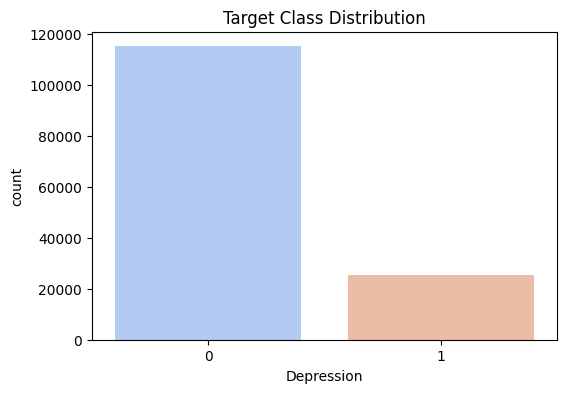

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x=train_data["Depression"], palette="coolwarm")
plt.title("Target Class Distribution")
plt.show()

### Function to encode categorical variables

What is Encoding Categorical Variables?
Categorical variables are features that represent groups or categories rather than numerical values.

Examples:


* Gender: ['Male', 'Female', 'Other']
* Color: ['Red', 'Blue', 'Green']
* City: ['New York', 'Los Angeles', 'Chicago']


Since machine learning models cannot process text directly, we need to convert categorical data into numerical form. The encode_categorical function performs this transformation.


In [5]:
def encode_categorical(series, is_train=True, mapping=None):
    """
    Encodes categorical features into numeric values.
    """
    if is_train:
        unique_values = series.unique()
        mapping = {val: idx for idx, val in enumerate(unique_values)}
    max_val = max(mapping.values()) if mapping else 0
    return series.map(lambda x: mapping.get(x, max_val + 1)), mapping

This function is designed to convert categorical variables into numerical representations, which is necessary because machine learning models work with numbers, not text.

```
def encode_categorical(series, is_train=True, mapping=None):
```

The function takes three parameters:
series: A pandas Series (column) containing categorical data.
is_train: A boolean indicating whether the function is running on training data.
mapping: A dictionary that stores the mapping of categorical values to numeric values.

``` if is_train:
    unique_values = series.unique()
    mapping = {val: idx for idx, val in enumerate(unique_values)} 
```

If the data is for training, the function:
    Extracts all unique values from the series.
    Creates a dictionary (mapping), where each unique category is assigned a unique number.

Example:
If the column contains:
```
['Male', 'Female', 'Other', 'Male']
```
The mapping will be:
```
{'Male': 0, 'Female': 1, 'Other': 2}
```

```
max_val = max(mapping.values()) if mapping else 0
```
This line finds the largest numeric value in the mapping.
This is useful in case new categories appear in test data.

```
return series.map(lambda x: mapping.get(x, max_val + 1)), mapping
```
Converts the original categorical column into numbers using the mapping dictionary.
If a category is not in the mapping, it is assigned max_val + 1 (new unseen category handling).
Returns:
The transformed column (numerical values).
The mapping dictionary (to be reused for test data).

### Function to preprocess data

The preprocess_data function is responsible for cleaning, encoding, and handling missing values in the dataset before feeding it into a machine learning model.

In [6]:
def preprocess_data(df, is_train=True, encoders=None):
    """
    Preprocesses the dataset by encoding categorical variables and handling missing values.
    """
    df = df.copy()
    
    # Drop irrelevant columns
    cols_to_drop = ['id', 'Name']
    if not is_train:
        cols_to_drop.append('Depression')
    df = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)
    
    if is_train:
        encoders = {}
    
    # Encode categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        if column != 'Depression':
            df[column], mapping = encode_categorical(
                df[column].astype(str),
                is_train=is_train,
                mapping=encoders.get(column)
            )
            if is_train:
                encoders[column] = mapping
    
    # Handle missing values in numerical columns
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_columns) > 0:
        imputer = SimpleImputer(strategy='median')
        df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
    
    # Convert all columns to float for model compatibility
    for col in df.columns:
        df[col] = df[col].astype(float)
    
    return df, encoders

```
def preprocess_data(df, is_train=True, encoders=None):

```
* df: The input dataset (Pandas DataFrame).
* is_train: A flag to determine whether the function is processing training data or test data.
* encoders: A dictionary containing mappings for categorical variables (used to ensure consistency between training and test datasets).

1. Copy the DataFrame
```

   df = df.copy()
```

This ensures that the original dataset remains unchanged.

2. Drop Irrelevant Columns

```
cols_to_drop = ['id', 'Name']
if not is_train:
    cols_to_drop.append('Depression')
df = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)

```

* The id and Name columns are dropped because they do not contribute to model predictions.
* If processing test data, the target column (Depression) is also dropped (since it won’t be available in real-world test scenarios).

3. Initialize Encoders for Categorical Variables

```

if is_train:
    encoders = {}
```
If this is training data, we create an empty dictionary (encoders) to store the categorical encodings.

4. Encode Categorical Columns

```
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if column != 'Depression':
        df[column], mapping = encode_categorical(
            df[column].astype(str),
            is_train=is_train,
            mapping=encoders.get(column)
        )
        if is_train:
            encoders[column] = mapping
```

* Finds all categorical columns (object type).
* Calls encode_categorical() function to convert categorical values to numeric values.
* If training, stores the mapping for future use (so test data is encoded consistently).

5. Handle Missing Values in Numerical Columns

```
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_columns) > 0:
    imputer = SimpleImputer(strategy='median')
    df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

```

* Identifies all numerical columns.
* Uses SimpleImputer(strategy='median') to fill missing values with the median of each column (more robust than the mean for skewed data)

6. Convert All Columns to float Type

```
for col in df.columns:
    df[col] = df[col].astype(float)
```
* Ensures that all values are numeric and consistent for model training.

7. Return Processed Data and Encoders

```
return df, encoders
```

Returns:
* The processed dataset.
* The encoders dictionary (for test data processing).



### Function to visualize feature importance

This function visualizes the top 10 most important features used by the trained machine learning model (XGBoost in this case).


* Helps in feature selection – Identify the most influential features.
* Improves model interpretability – Understand which factors contribute most to predictions.
* Optimizes model performance – If unimportant features are removed, the model may generalize better.

In [7]:
def plot_feature_importance(model, features):
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Important Features')
    plt.show()

```
def plot_feature_importance(model, features):

```
* model: The trained XGBoost model.
* features: A list of feature names (column names from the dataset).

1. Extract Feature Importance

```
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

```

* Creates a Pandas DataFrame that maps each feature to its importance score.
* The feature_importances_ attribute of the model provides importance scores for each feature.
* Sorts the features in descending order (most important features at the top).
  
2. Plot the Feature Importance

```
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features')
plt.show()
```

* Creates a bar plot using Seaborn (sns.barplot).
* Plots the top 10 most important features.
* The x-axis represents importance scores, while the y-axis represents feature names.
plt.show() displays the plot.



### Function to train the model

This function trains an XGBoost classifier to predict depression based on the preprocessed dataset.




In [8]:
def train_model(train_data):
    """
    Trains an XGBoost model on the processed dataset.
    """
    X = train_data.drop('Depression', axis=1)
    y = train_data['Depression']
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': 5,
        'learning_rate': 0.005,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'n_estimators': 5000,
        'verbosity': 0,
        'early_stopping_rounds': 50,
    }
    
    # Train the model
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],
        verbose=100
    )
    
    # Evaluate the model
    val_predictions = model.predict(X_val)
    print("\nValidation Metrics:")
    print(classification_report(y_val, val_predictions))
    print(f"Validation Accuracy: {accuracy_score(y_val, val_predictions):.4f}")
    
    return model, X.columns

```

def train_model(train_data):
```

Takes in preprocessed training data as input.

1. Splitting Features (X) and Target (y)

```
X = train_data.drop('Depression', axis=1)
y = train_data['Depression']

```

* X contains all independent features (excluding the Depression column).
* y is the target variable (Depression label: 1 = Depressed, 0 = Not Depressed).

2. Splitting the Dataset
```

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
```

* Splits data into 80% training and 20% validation.
* random_state=42 ensures consistent results.

3. Defining XGBoost Parameters


```

params = {
    'objective': 'binary:logistic',  # Binary classification problem
    'eval_metric': 'logloss',        # Logarithmic loss as evaluation metric
    'max_depth': 5,                  # Limits tree depth (prevents overfitting)
    'learning_rate': 0.005,           # Controls step size during optimization
    'subsample': 0.9,                 # Uses 90% of data per boosting round
    'colsample_bytree': 0.9,          # Uses 90% of features per tree
    'n_estimators': 5000,             # Number of trees (boosting rounds)
    'verbosity': 0,                   # Suppresses output
    'early_stopping_rounds': 50,      # Stops training if validation loss doesn't improve
}

```

* Early stopping prevents overfitting by stopping training when performance stops improving.


4. Training the XGBoost Model

```
model = xgb.XGBClassifier(**params)
model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)],  # Tracks validation performance
    verbose=100
)
```


* Creates an XGBoost classifier and fits it on the training data.
* Monitors validation set for performance.

5. Evaluating the Model

```
val_predictions = model.predict(X_val)
print("\nValidation Metrics:")
print(classification_report(y_val, val_predictions))
print(f"Validation Accuracy: {accuracy_score(y_val, val_predictions):.4f}")

```
* Generates predictions on validation data.
* Prints a classification report with precision, recall, and F1-score.
* Displays validation accuracy.

6. Returning the Model & Feature Names

```
return model, X.columns

```
Returns:
* Trained model
* List of feature names (for visualization later)


In [9]:


# Set professional aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (10, 6)
})

def plot_target_distribution(data):
    """
    Plots the class distribution of the target variable 'Depression'.
    """
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=data["Depression"], palette="Blues_r")
    plt.title("Depression Class Distribution", fontsize=14, fontweight="bold")
    plt.xlabel("Depression", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + 0.2, p.get_height() + 10), fontsize=12)
    plt.show()

def plot_feature_importance(model, features):
    """
    Plots the top 10 important features of the trained model.
    """
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10), palette="viridis")
    plt.title('Top 10 Important Features', fontsize=14, fontweight="bold")
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

def plot_correlation_heatmap(data):
    """
    Plots a heatmap of feature correlations.
    """
    plt.figure(figsize=(12, 8))
    corr_matrix = data.corr()
    sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
    plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold")
    plt.show()


### Main function to execute the workflow


Loading and preprocessing data...

Training data columns: ['id', 'Name', 'Gender', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']
Test data columns: ['id', 'Name', 'Gender', 'Age', 'City', 'Working Professional or Student', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness']

Training model...
[0]	validation_0-logloss:0.47760
[100]	validation_0-logloss:0.32165
[200]	validation_0-logloss:0.25191
[300]	validation_0-logloss:0.21425
[400]	validation_0-logloss:0.19255
[500]	validation_0-logloss:0.17938
[6

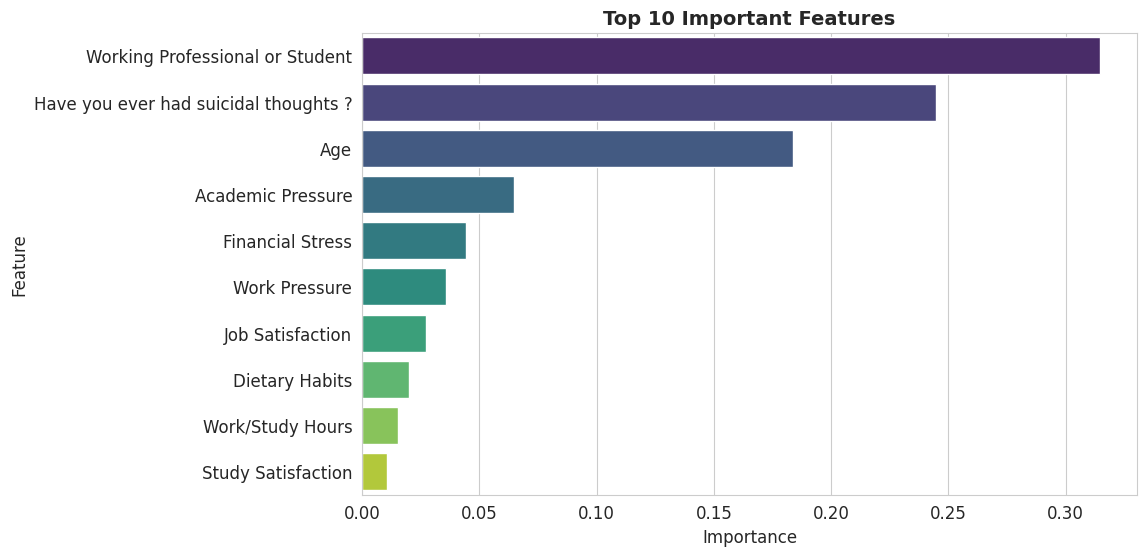


Making predictions on test data...

Submission file created: submission_xgboost.csv

Model saved as: depression_prediction_xgboost.model


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:19:52] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


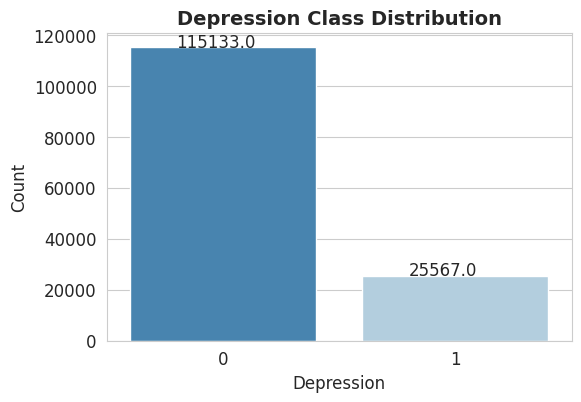

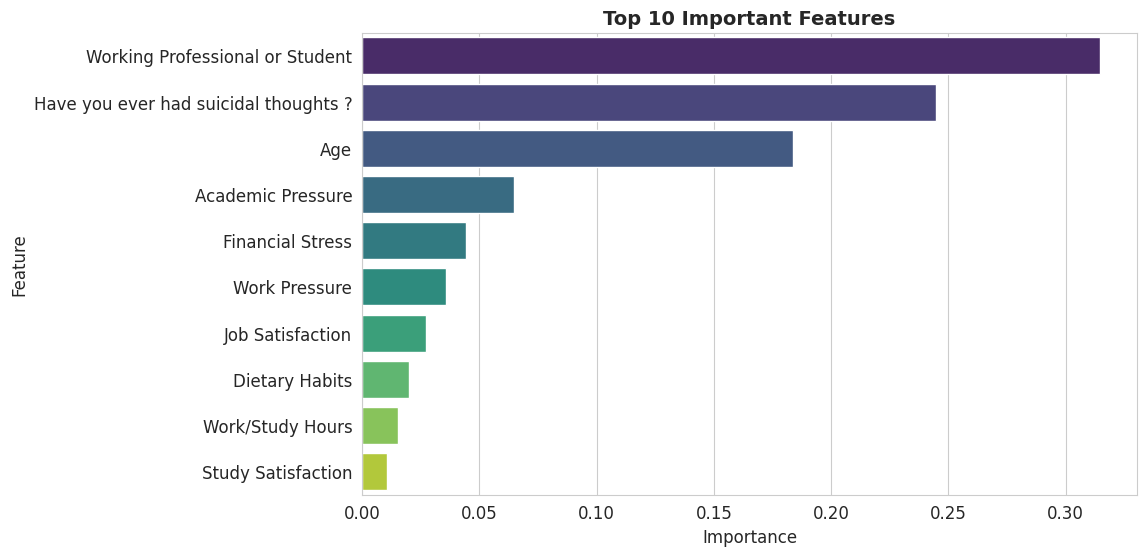

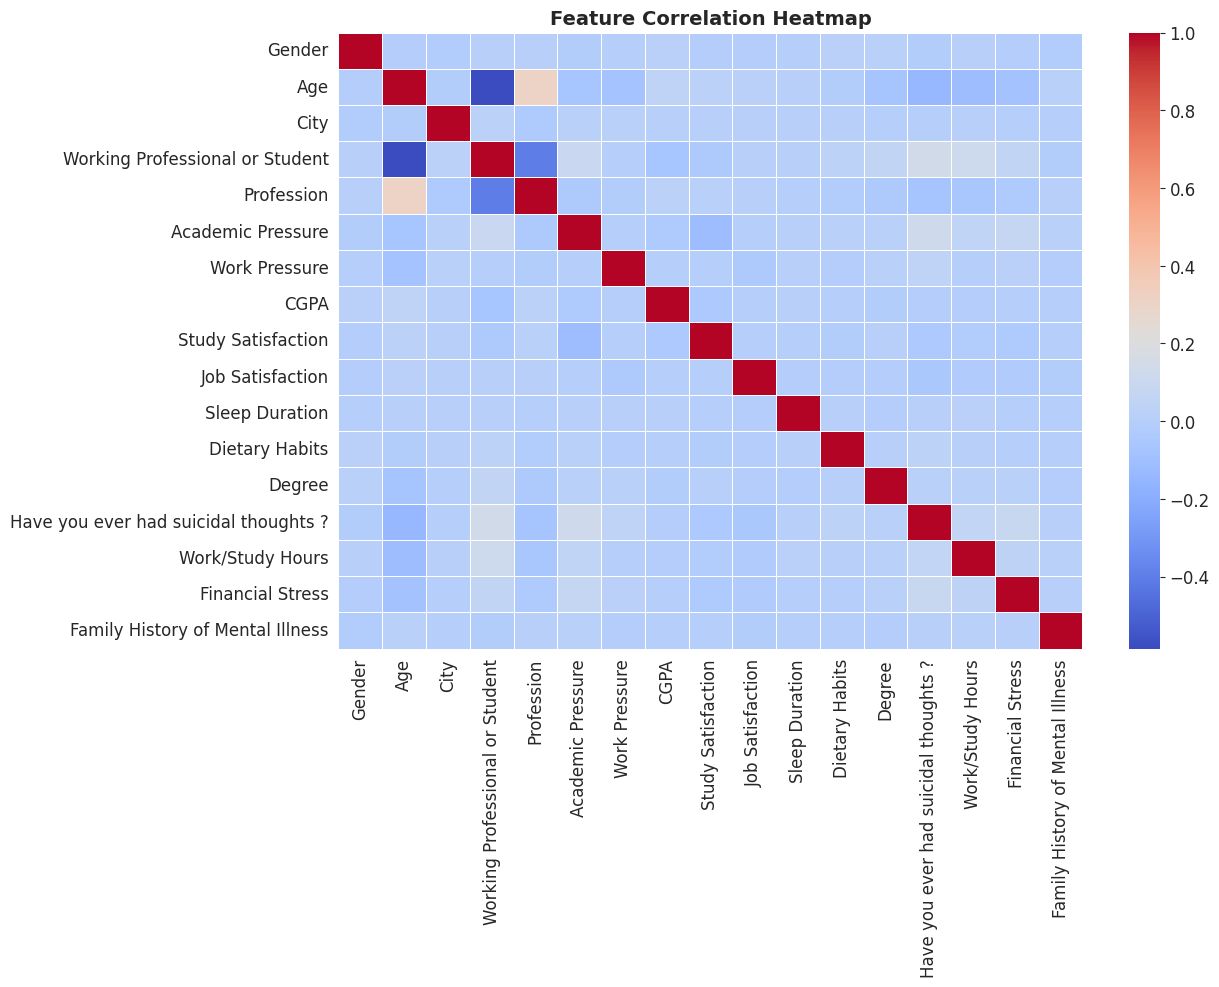

In [10]:
def main():
    try:
        # Load data
        print("Loading and preprocessing data...")
        train_data = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/train.csv')
        test_data = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/test.csv')
        
        # Print initial column names for debugging
        print("\nTraining data columns:", train_data.columns.tolist())
        print("Test data columns:", test_data.columns.tolist())
        
        # Preprocess training data
        processed_train, encoders = preprocess_data(train_data, is_train=True)
        
        # Train model
        print("\nTraining model...")
        model, features = train_model(processed_train)
        
        # Visualize feature importance
        plot_feature_importance(model, features)
        
        # Process test data using the same encoders
        processed_test, _ = preprocess_data(test_data, is_train=False, encoders=encoders)
        
        # Ensure columns match between train and test
        train_cols = processed_train.drop('Depression', axis=1).columns
        processed_test = processed_test[train_cols]
        
        # Make predictions on test data
        print("\nMaking predictions on test data...")
        test_predictions = model.predict(processed_test)
        
        # Create submission file
        submission = pd.DataFrame({
            'id': test_data['id'],
            'Depression': test_predictions
        })
        submission.to_csv('submission.csv', index=False)
        print("\nSubmission file created: submission_xgboost.csv")
        
        # Save model
        model.save_model('depression_prediction_xgboost.model')
        print("\nModel saved as: depression_prediction_xgboost.model")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        print("\nDetailed error information:")
        print(traceback.format_exc())


    # Plot target class distribution
    plot_target_distribution(train_data)

    # Plot feature importance
    plot_feature_importance(model, features)

    # Plot correlation heatmap (excluding target variable)
    plot_correlation_heatmap(processed_train.drop(columns=["Depression"]))


    


# Execute main function
if __name__ == "__main__":
    main()


1. Loading the Data

```

train_data = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/train.csv')
test_data = pd.read_csv('/kaggle/input/predicting-depression-machine-learning-challenge/test.csv')
```
2. Debugging Column Names

```
print("\nTraining data columns:", train_data.columns.tolist())
print("Test data columns:", test_data.columns.tolist())

```

* Prints the column names to ensure consistency between train & test sets.
* Helps debug missing or extra columns.


3. Preprocessing the Data

```

processed_train, encoders = preprocess_data(train_data, is_train=True)
```

* Calls preprocess_data(), which:
  * Encodes categorical features.
  * Handles missing values.
  * Removes irrelevant columns (id, Name).
* encoders stores mappings for categorical encoding.



4. Training the Model

```
model, features = train_model(processed_train)

```

Calls train_model(), which:
* Splits data into training and validation sets.
* Trains an XGBoost model.
Evaluates the model using accuracy and classification metrics.
Returns:
* Trained model (model).
* Feature names (features) for visualization.

5. Feature Importance Visualization

```
plot_feature_importance(model, features)

```

* Uses plot_feature_importance() to identify key predictors.
* Displays a bar chart of the top 10 most important features.

6. Processing the Test Data

```
processed_test, _ = preprocess_data(test_data, is_train=False, encoders=encoders)

```

* Ensures test data undergoes the same preprocessing.
* Uses the same encoders as training data to maintain consistency.

7. Aligning Test Columns with Train Columns

```

train_cols = processed_train.drop('Depression', axis=1).columns
processed_test = processed_test[train_cols]
```

* Ensures the test dataset has the same feature set as the training data.
* Prevents column mismatch errors when making predictions.


8. Making Predictions
   
```

test_predictions = model.predict(processed_test)
```

Uses the trained model to predict depression likelihood for the test data.

